In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import logging
from IPython.display import display

# Setup logging
logging.basicConfig(filename='model_training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

print("Library dan logging setup selesai.")


Library dan logging setup selesai.


In [2]:
# Load the data from the provided Excel file
file_path = 'data_x.xlsx'  # Ganti dengan path ke file Excel yang kamu miliki
data = pd.read_excel(file_path)

# Logging the data loading
logging.info("Data loaded successfully.")
print("Data berhasil dimuat.")
display(data.head())


Data berhasil dimuat.


,Nama,Usia (bulan),Jenis Kelamin,pendapatan,tinggi,berat,air_bersih,kondisi_sanitasi,susu_formula,status_stunting
0,Agus Nugroho,28,Laki-laki,2200000,66,8.9,Baik,Baik,Ya,Ya
1,Andre Wibowo,24,Laki-laki,2000000,65,8.5,Cukup,Baik,Ya,Ya
2,Budi Susanto,25,Laki-laki,1700000,67,8.7,Buruk,Buruk,Ya,Ya
3,Dewi Ayu,31,Perempuan,2000000,76,10.2,Buruk,Buruk,Ya,Tidak
4,Dina Rahayu,32,Perempuan,1900000,71,9.8,Baik,Buruk,Ya,Tidak


In [3]:
# Preprocessing data
# Convert categorical features to numerical values based on the specified range

# Definisikan rentang untuk setiap kolom
def map_pendapatan(pendapatan):
    if pendapatan < 1000000:
        return 1
    elif 1000000 <= pendapatan < 2000000:
        return 2
    elif 2000000 <= pendapatan < 3000000:
        return 3
    elif 3000000 <= pendapatan < 4000000:
        return 4
    else:
        return 5

def map_tinggi(tinggi):
    if tinggi < 60:
        return 1
    elif 60 <= tinggi < 70:
        return 2
    elif 70 <= tinggi < 80:
        return 3
    elif 80 <= tinggi < 90:
        return 4
    else:
        return 5

def map_berat(berat):
    if berat < 5:
        return 1
    elif 5 <= berat < 10:
        return 2
    elif 10 <= berat < 15:
        return 3
    elif 15 <= berat < 20:
        return 4
    else:
        return 5

def map_air_bersih(air_bersih):
    return {'Buruk': 1, 'Cukup': 2, 'Baik': 3, 'Sangat Baik': 4}.get(air_bersih, 0)

def map_kondisi_sanitasi(kondisi_sanitasi):
    return {'Buruk': 1, 'Cukup': 2, 'Baik': 3, 'Sangat Baik': 4}.get(kondisi_sanitasi, 0)

def map_susu_formula(susu_formula):
    return {'Tidak': 1, 'Ya': 2}.get(susu_formula, 0)

data['pendapatan'] = data['pendapatan'].apply(map_pendapatan)
data['tinggi'] = data['tinggi'].apply(map_tinggi)
data['berat'] = data['berat'].apply(map_berat)
data['air_bersih'] = data['air_bersih'].apply(map_air_bersih)
data['kondisi_sanitasi'] = data['kondisi_sanitasi'].apply(map_kondisi_sanitasi)
data['susu_formula'] = data['susu_formula'].apply(map_susu_formula)

# Convert target variable to numerical values
data['status_stunting'] = data['status_stunting'].map({'Ya': 1, 'Tidak': 0})

# Logging the preprocessing step
logging.info("Data preprocessing completed.")
print("Preprocessing data selesai.")
display(data.head())


Preprocessing data selesai.


,Nama,Usia (bulan),Jenis Kelamin,pendapatan,tinggi,berat,air_bersih,kondisi_sanitasi,susu_formula,status_stunting
0,Agus Nugroho,28,Laki-laki,3,2,2,3,3,2,1
1,Andre Wibowo,24,Laki-laki,3,2,2,2,3,2,1
2,Budi Susanto,25,Laki-laki,2,2,2,1,1,2,1
3,Dewi Ayu,31,Perempuan,3,3,3,1,1,2,0
4,Dina Rahayu,32,Perempuan,2,3,2,3,1,2,0


In [4]:
# Define features and target variable
selected_columns = ['pendapatan', 'tinggi', 'berat', 'air_bersih', 'kondisi_sanitasi', 'susu_formula']

X = data[selected_columns]
y = data['status_stunting']

# Add a constant column for the intercept term
X = sm.add_constant(X)

print("Definisi fitur dan variabel target selesai.")
display(X.head())
display(y.head())


Definisi fitur dan variabel target selesai.


,const,pendapatan,tinggi,berat,air_bersih,kondisi_sanitasi,susu_formula
0,1.0,3,2,2,3,3,2
1,1.0,3,2,2,2,3,2
2,1.0,2,2,2,1,1,2
3,1.0,3,3,3,1,1,2
4,1.0,2,3,2,3,1,2


0    1
1    1
2    1
3    0
4    0
Name: status_stunting, dtype: int64

In [5]:
# Backward Elimination process
def backward_elimination(X, y, significance_level=0.05):
    num_vars = X.shape[1]
    for i in range(num_vars):
        regressor_ols = sm.OLS(y, X).fit()
        max_p_value = max(regressor_ols.pvalues)
        adj_r_before = regressor_ols.rsquared_adj
        if max_p_value > significance_level:
            for j in range(num_vars - i):
                if regressor_ols.pvalues.iloc[j] == max_p_value:  # Use iloc to access value by position
                    X = X.drop(X.columns[j], axis=1)
                    tmp_regressor = sm.OLS(y, X).fit()
                    adj_r_after = tmp_regressor.rsquared_adj
                    if adj_r_before >= adj_r_after:
                        X = X.drop(X.columns[-1], axis=1)
                        return X
    regressor_ols.summary()
    return X

# Apply Backward Elimination
X_modeled = backward_elimination(X, y)

# Logging the feature selection step
selected_features = X_modeled.columns
logging.info(f"Selected features: {selected_features}")
print(f"Fitur yang dipilih: {selected_features}")
display(X_modeled.head())


Fitur yang dipilih: Index(['const', 'tinggi'], dtype='object')


,const,tinggi
0,1.0,2
1,1.0,2
2,1.0,2
3,1.0,3
4,1.0,3


In [7]:
# Use the entire dataset for training since we are using labeled data for training
X_train = X_modeled
y_train = y

# Initialize and train the Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Logging the training step
logging.info("Model training completed.")
print("Pelatihan model selesai.")

# Save the trained model to a file
model_filename = 'naive_bayes_stunting_model.pkl'
joblib.dump(nb, model_filename)

# Logging the model saving step
logging.info(f"Model has been trained and saved to {model_filename}")
print(f"Model telah dilatih dan disimpan ke {model_filename}")

# Display the selected features and their ranking
feature_ranking = pd.DataFrame({
    'Feature': selected_features,
    'Ranking': range(1, len(selected_features) + 1)
})

# Save the feature ranking to a file
feature_ranking.to_csv('feature_ranking.csv', index=False)

# Logging the feature ranking
logging.info(f"Feature ranking:\n{feature_ranking.to_string(index=False)}")
print("Penyimpanan model dan ranking fitur selesai.")
display(feature_ranking)


Pelatihan model selesai.
Model telah dilatih dan disimpan ke naive_bayes_stunting_model.pkl
Penyimpanan model dan ranking fitur selesai.


,Feature,Ranking
0,const,1
1,tinggi,2


In [8]:
# Initialize and train the Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Logging the training step
logging.info("Model training completed.")
print("Pelatihan model selesai.")


Pelatihan model selesai.


In [10]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_modeled, y, test_size=0.2, random_state=42)

# Initialize and train the Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Logging the training step
logging.info("Model training completed.")
print("Pelatihan model selesai.")

# Make predictions
y_pred = nb.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame to display the results
results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
})

# Save the evaluation metrics to a file
results.to_csv('model_evaluation_metrics.csv', index=False)

# Logging the evaluation results
logging.info(f"Model evaluation metrics:\n{results.to_string(index=False)}")
print("Prediksi dan perhitungan metrik evaluasi selesai.")
display(results)


Pelatihan model selesai.
Prediksi dan perhitungan metrik evaluasi selesai.


,Metric,Score
0,Accuracy,1.0
1,Precision,1.0
2,Recall,1.0
3,F1 Score,1.0


Persentase klasifikasi dalam data:


,Class,Percentage
0,Tidak Stunting,60.0
1,Stunting,40.0


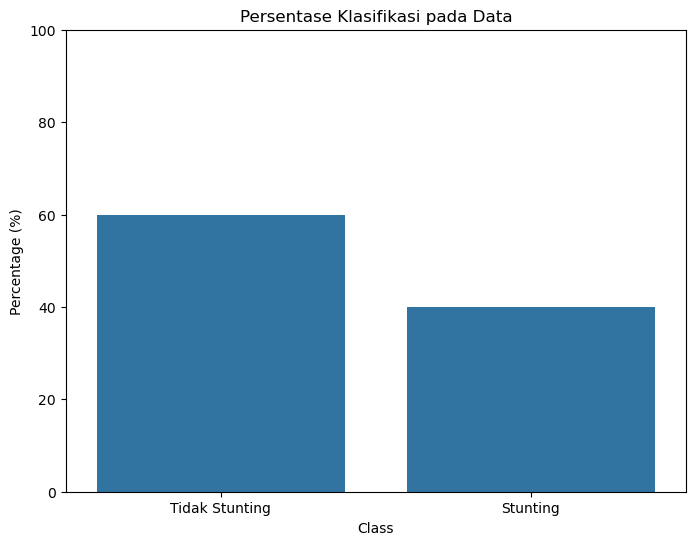

In [11]:
# Calculate the percentage of each class in the dataset
class_counts = data['status_stunting'].value_counts(normalize=True) * 100

# Create a DataFrame to display the class percentages
class_percentages = pd.DataFrame({
    'Class': ['Tidak Stunting', 'Stunting'],
    'Percentage': [class_counts[0], class_counts[1]]
})

# Logging the class percentages
logging.info(f"Class percentages:\n{class_percentages.to_string(index=False)}")
print("Persentase klasifikasi dalam data:")
display(class_percentages)

# Plot the class percentages
plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Percentage', data=class_percentages)
plt.title('Persentase Klasifikasi pada Data')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.ylim(0, 100)
plt.savefig('class_percentages.png')
plt.show()


In [12]:
# Save the trained model to a file
model_filename = 'naive_bayes_stunting_model.pkl'
joblib.dump(nb, model_filename)

# Logging the model saving step
logging.info(f"Model has been trained and saved to {model_filename}")
print(f"Model telah dilatih dan disimpan ke {model_filename}")

# Display the selected features and their ranking
feature_ranking = pd.DataFrame({
    'Feature': selected_features,
    'Ranking': range(1, len(selected_features) + 1)
})

# Save the feature ranking to a file
feature_ranking.to_csv('feature_ranking.csv', index=False)

# Logging the feature ranking
logging.info(f"Feature ranking:\n{feature_ranking.to_string(index=False)}")
print("Penyimpanan model dan ranking fitur selesai.")
display(feature_ranking)


Model telah dilatih dan disimpan ke naive_bayes_stunting_model.pkl
Penyimpanan model dan ranking fitur selesai.


,Feature,Ranking
0,const,1
1,tinggi,2


In [13]:
# Load the test data from the provided Excel file
file_path_test = 'data_uji.xlsx'  # Ganti dengan path ke file Excel data uji yang kamu miliki
data_uji = pd.read_excel(file_path_test)

# Load the training data from the provided Excel file
file_path_train = 'data_latih.xlsx'  # Ganti dengan path ke file Excel data latih yang kamu miliki
data_latih = pd.read_excel(file_path_train)

# Display the first few rows of the test and training data
print("Data uji berhasil dimuat:")
display(data_uji.head())
print("Data latih berhasil dimuat:")
display(data_latih.head())

Data uji berhasil dimuat:


,nama_keluarga,jenis_kelamin,usia,pendapatan,tinggi,berat,air_bersih,kondisi_sanitasi,susu_formula
0,Keluarga A,Laki-laki,24,1500000,68,8.0,Baik,Baik,Ya
1,Keluarga B,Perempuan,30,2500000,75,9.5,Cukup,Cukup,Tidak
2,Keluarga C,Laki-laki,18,1200000,60,6.0,Buruk,Buruk,Ya
3,Keluarga D,Perempuan,22,3000000,85,12.0,Sangat Baik,Sangat Baik,Tidak
4,Keluarga E,Laki-laki,25,1800000,78,10.0,Cukup,Baik,Ya


Data latih berhasil dimuat:


,Nama,Usia (bulan),Jenis Kelamin,pendapatan,tinggi,berat,air_bersih,kondisi_sanitasi,susu_formula,status_stunting
0,Agus Nugroho,28,Laki-laki,2200000,66,8.9,Baik,Baik,Ya,Ya
1,Andre Wibowo,24,Laki-laki,2000000,65,8.5,Cukup,Baik,Ya,Ya
2,Budi Susanto,25,Laki-laki,1700000,67,8.7,Buruk,Buruk,Ya,Ya
3,Dewi Ayu,31,Perempuan,2000000,76,10.2,Buruk,Buruk,Ya,Tidak
4,Dina Rahayu,32,Perempuan,1900000,71,9.8,Baik,Buruk,Ya,Tidak


In [14]:
# Definisikan fungsi preprocessing
def map_pendapatan(pendapatan):
    if pendapatan < 1000000:
        return 1
    elif 1000000 <= pendapatan < 2000000:
        return 2
    elif 2000000 <= pendapatan < 3000000:
        return 3
    elif 3000000 <= pendapatan < 4000000:
        return 4
    else:
        return 5

def map_tinggi(tinggi):
    if tinggi < 60:
        return 1
    elif 60 <= tinggi < 70:
        return 2
    elif 70 <= tinggi < 80:
        return 3
    elif 80 <= tinggi < 90:
        return 4
    else:
        return 5

def map_berat(berat):
    if berat < 5:
        return 1
    elif 5 <= berat < 10:
        return 2
    elif 10 <= berat < 15:
        return 3
    elif 15 <= berat < 20:
        return 4
    else:
        return 5

def map_air_bersih(air_bersih):
    return {'Buruk': 1, 'Cukup': 2, 'Baik': 3, 'Sangat Baik': 4}.get(air_bersih, 0)

def map_kondisi_sanitasi(kondisi_sanitasi):
    return {'Buruk': 1, 'Cukup': 2, 'Baik': 3, 'Sangat Baik': 4}.get(kondisi_sanitasi, 0)

def map_susu_formula(susu_formula):
    return {'Tidak': 1, 'Ya': 2}.get(susu_formula, 0)

def preprocess_data(data):
    # Apply preprocessing functions
    data['pendapatan'] = data['pendapatan'].apply(map_pendapatan)
    data['tinggi'] = data['tinggi'].apply(map_tinggi)
    data['berat'] = data['berat'].apply(map_berat)
    data['air_bersih'] = data['air_bersih'].apply(map_air_bersih)
    data['kondisi_sanitasi'] = data['kondisi_sanitasi'].apply(map_kondisi_sanitasi)
    data['susu_formula'] = data['susu_formula'].apply(map_susu_formula)

    # Ensure the test data has the same features as the training data
    selected_columns = ['pendapatan', 'tinggi', 'berat', 'air_bersih', 'kondisi_sanitasi', 'susu_formula']
    X_data = data[selected_columns]

    # Add a constant column for the intercept term
    X_data.insert(0, 'const', 1)

    return X_data

# Preprocess the test and training data
X_test_uji = preprocess_data(data_uji)
X_train = preprocess_data(data_latih)
y_train = data_latih['status_stunting']

print("Preprocessing data uji selesai:")
display(X_test_uji.head())
print("Preprocessing data latih selesai:")
display(X_train.head())


Preprocessing data uji selesai:


,const,pendapatan,tinggi,berat,air_bersih,kondisi_sanitasi,susu_formula
0,1,2,2,2,3,3,2
1,1,3,3,2,2,2,1
2,1,2,2,2,1,1,2
3,1,4,4,3,4,4,1
4,1,2,3,3,2,3,2


Preprocessing data latih selesai:


,const,pendapatan,tinggi,berat,air_bersih,kondisi_sanitasi,susu_formula
0,1,3,2,2,3,3,2
1,1,3,2,2,2,3,2
2,1,2,2,2,1,1,2
3,1,3,3,3,1,1,2
4,1,2,3,2,3,1,2


In [16]:
# Initialize and train the Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Verify the training process
print("Model berhasil dilatih.")


Model berhasil dilatih.


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test data
predictions = nb_model.predict(X_test_uji)

# Print the raw predictions
print("Prediksi (raw):", predictions)

# Add predictions to the test data
data_uji['status_stunting_predicted'] = predictions

# Verify that the predictions are added correctly
print("Data uji setelah prediksi:")
display(data_uji[['nama_keluarga', 'jenis_kelamin', 'usia', 'pendapatan', 'tinggi', 'berat', 'air_bersih', 'kondisi_sanitasi', 'susu_formula', 'status_stunting_predicted']])

# Save the test data with predictions to a new Excel file
output_file_path = 'data_uji_dengan_prediksi.xlsx'
data_uji.to_excel(output_file_path, index=False)

print(f"Data uji dengan prediksi disimpan ke {output_file_path}")



Prediksi (raw): ['Ya' 'Tidak' 'Tidak' 'Tidak' 'Tidak']
Data uji setelah prediksi:


,nama_keluarga,jenis_kelamin,usia,pendapatan,tinggi,berat,air_bersih,kondisi_sanitasi,susu_formula,status_stunting_predicted
0,Keluarga A,Laki-laki,24,2,2,2,3,3,2,Ya
1,Keluarga B,Perempuan,30,3,3,2,2,2,1,Tidak
2,Keluarga C,Laki-laki,18,2,2,2,1,1,2,Tidak
3,Keluarga D,Perempuan,22,4,4,3,4,4,1,Tidak
4,Keluarga E,Laki-laki,25,2,3,3,2,3,2,Tidak


Data uji dengan prediksi disimpan ke data_uji_dengan_prediksi.xlsx


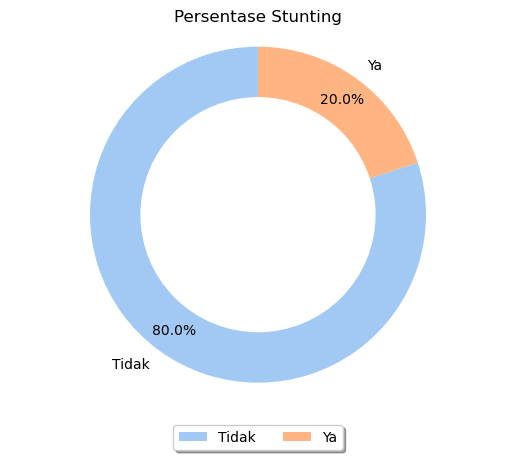

In [18]:
# Create a donut chart
stunting_counts = data_uji['status_stunting_predicted'].value_counts()
labels = stunting_counts.index
sizes = stunting_counts.values
colors = sns.color_palette('pastel')[0:2]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Persentase Stunting')

# Add legend and make the chart interactive
plt.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()